# Project Title
### Data Engineering Capstone Project

#### Project Summary
This project aims to provide analyzes and explanations and questions that may come to our mind, such as:

1- What are the most frequent months of the year the migration takes place?

2- do populous states attract more visitors every month? 


Using datasets like I94 immigration, global land temperatures, and US demographics, I will try to answer all of them with the creation of an ETL Pipeline to model those datasets.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [34]:
# Do all imports and installs here
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import datetime as dt
from pyspark.sql.types import *

## Step 1: Scope the Project and Gather Data

### Scope 
<hr></hr>

1- Prohect steps
2- 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### 1. Project steps:
<hr></hr>

* create a spark session, and load the data into dataframe
* apply EDA on the datasets(I94 immigration, global land temperatures, and US demographics)
* dealing with any NA values and duplicated values in my datasets
* plot some charts to help me to know my data more and to get some insights and correlations between the datasets 
* design the data modeling (fact and dimensions):
   - The country dimension table: 
   - Us demographics dimension table:
   - The immigration calendar table:
   - The visa type dimension table:
   - The immigration fact table 

    
#### 2. technologies 
* Amazon Simple Storage Service (AWS S3)
* Apache spark and pyspark 
* Pandas Dataframe 

### Describe and Gather Data 
<hr></hr>

#### 1. I94 Immigration Data:
* Data Description
    - This data comes from the US National Tourism and Trade Office, It is a dataset that contains information about international visitors to the United States who are admitted into the country using an I-94 form. The dataset is collected and maintained by the United States Customs and Border Protection (CBP) agency and includes data such as the visitor's country of origin, port of entry, mode of transportation, date of arrival, duration of stay, and other demographic information.
    
* Data source:
    - https://www.trade.gov/national-travel-and-tourism-office  

* Data division
    - This dataset forms the core of the data warehouse and the customer repository has a years worth of data for the year 2016 and the dataset is divided by month. For this project the data is in a folder located at ../../data/18-83510-I94-Data-2016/. Each months data is stored in an SAS binary database storage format sas7bdat. For this project we have chosen going to work with data for the month of April. However, the data extraction, transformation and loading utility functions have been designed to work with any month's worth of data.
    
    
#### 2. World Temperature Data:
* Data Description:
    -  It is a dataset that contains information about global temperatures over time, dating back to the mid-19th century. The dataset is compiled from various sources, including weather stations, ships, and satellites, and includes measurements of temperature, humidity, pressure, and other climate variables.
    
* Data source:
    - https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

#### 3. U.S. City Demographic Data
* Data Description:
    - It is a dataset that contains demographic information about cities and towns in the United States. The dataset includes data such as population size, race and ethnicity, age distribution, education level, household income, and other socioeconomic indicators.

* Data Source:
    - https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/


## 1. I94 Immigration Dataset

### Create a spark session 

In [2]:
# SparkSession.builder: This creates a new SparkSession.Builder object that can be used to configure the SparkSession.
# config("spark.jars.repositories", "https://repos.spark-packages.org/"): This sets a configuration option for the SparkSession. Specifically, it sets the spark.jars.repositories option to the value https://repos.spark-packages.org/. This option tells Spark where to look for external packages when you run Spark jobs.
# config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11"): This sets another configuration option, spark.jars.packages, to the value saurfang:spark-sas7bdat:2.0.0-s_2.11. This option tells Spark to download and include the saurfang:spark-sas7bdat package, which provides support for reading SAS data files in Spark.
# enableHiveSupport(): This enables support for Hive metastore connectivity in the SparkSession. This is necessary if you want to use the Spark SQL API to interact with data stored in a Hive metastore.
# getOrCreate(): This creates a new SparkSession if one doesn't already exist, or returns the existing SparkSession if there is one.

spark = SparkSession.builder.\
    config("spark.jars.repositories", "https://repos.spark-packages.org/").\
    config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

In [3]:
# read in the data
fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
imm_df =spark.read.format('com.github.saurfang.sas.spark').load(fname)
# display the first five records
imm_df.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,...,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


In [4]:
# Get row count
rows = imm_df.count()
print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(imm_df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 3096313
DataFrame Columns count : 28


In [5]:
# Retrieve the schema of Dataframe
imm_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [6]:
# from pyspark.sql import SparkSession

# spark = SparkSession.builder.\
# config("spark.jars.repositories", "https://repos.spark-packages.org/").\
# config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
# enableHiveSupport().getOrCreate()

# df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [7]:
# #write to parquet
# df_spark.write.parquet("sas_data")
# df_spark=spark.read.parquet("sas_data")

## World Tempreture Dataset

In [8]:
file_name = '../../data2/GlobalLandTemperaturesByCity.csv'
temp_df = pd.read_csv(file_name, index_col=None )
temp_df.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [9]:
# Get row count
rows = len(temp_df.index)

print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(temp_df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 8599212
DataFrame Columns count : 7


In [10]:
# Retrieve the schema
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
dt                               object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


## U.S. City Demographic Data

In [11]:
file_name = 'us-cities-demographics.csv'
demo_df = pd.read_csv(file_name, index_col=None , sep = ";")
demo_df.head(5)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [12]:
# Get row count
rows = len(demo_df.index)

print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(demo_df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 2891
DataFrame Columns count : 12


In [13]:
# Retrieve the schema
demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
City                      2891 non-null object
State                     2891 non-null object
Median Age                2891 non-null float64
Male Population           2888 non-null float64
Female Population         2888 non-null float64
Total Population          2891 non-null int64
Number of Veterans        2878 non-null float64
Foreign-born              2878 non-null float64
Average Household Size    2875 non-null float64
State Code                2891 non-null object
Race                      2891 non-null object
Count                     2891 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 271.1+ KB


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
* Drop columns with significant missing values
* Drop all duplicated rows 
* change some column names 

### 1. I94 Immigration Dataset¶

In [14]:
import pyspark.sql.functions as F
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

missing_count = count_missings(imm_df)
missing_count['percentage_missing'] = [(missing_count.iloc[:,0][i]/3096313)*100 for i in range(missing_count.shape[0])]
missing_count

,count,percentage_missing
entdepu,3095921,99.987340
occup,3088187,99.737559
insnum,2982605,96.327632
visapost,1881250,60.757746
gender,414269,13.379429
i94addr,152592,4.928184
depdate,142457,4.600859
matflag,138429,4.470769
entdepd,138429,4.470769
airline,83627,2.700857


##### If a column has more than 90% of its values missing, it may not provide enough data to be used for analysis. Therefore, it is recommended to remove such columns from the dataset. Additionally, it is recommended to remove any rows that have no data available, meaning all values in that row are missing.

In [15]:
# columns with over 90% missing values
over_90_cols = ['occup', 'entdepu','insnum']

# drop these columns
new_imm_df = imm_df.drop(*over_90_cols)

In [16]:
print("num of columns before dropping", len(imm_df.columns))
print("num of columns after dropping", len(new_imm_df.columns))

num of columns before dropping 28
num of columns after dropping 25


In [17]:
new_imm_df = new_imm_df.dropDuplicates()

In [18]:
# Get row count
rows = imm_df.count()
print(f"DataFrame before cleaning process: {rows}")

rows = new_imm_df.count()
print(f"DataFrame after cleaning process: {rows}")


DataFrame before cleaning process: 3096313
DataFrame after cleaning process: 3096313


### World Tempreture Dataset

In [19]:
percent_missing = temp_df.isnull().sum() * 100 / len(temp_df)
missing_value_df = pd.DataFrame({'column_name': temp_df.columns,
                                 'percent_missing': percent_missing})
missing_value_df 

,column_name,percent_missing
dt,dt,0.000000
AverageTemperature,AverageTemperature,4.234458
AverageTemperatureUncertainty,AverageTemperatureUncertainty,4.234458
City,City,0.000000
Country,Country,0.000000
Latitude,Latitude,0.000000
Longitude,Longitude,0.000000


In [20]:
num_rows_before = temp_df.shape[0]

In [21]:
temp_df.dropna( inplace=True)

In [22]:
# Drop duplicates 
temp_df = temp_df.drop_duplicates()

In [23]:
num_rows_after = temp_df.shape[0]
print("number of rows before cleaning process: ",num_rows_before)
print("number of rows after cleaning process: ",num_rows_after)

number of rows before cleaning process:  8599212
number of rows after cleaning process:  8235082


In [24]:
temp_df['months'] = [temp_df['dt'].iloc[i][5:7] for i in range(temp_df.shape[0])]
temp_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,months
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E,11
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E,04
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E,05
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E,06
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E,07


In [25]:
groupby_month = temp_df.groupby("months")["AverageTemperature"].mean()
groupby_month

months
01     9.287094
02    10.641474
03    13.619809
04    17.050127
05    20.155098
06    22.110560
07    23.093493
08    22.777298
09    20.695404
10    17.337906
11    13.630688
12    10.330352
Name: AverageTemperature, dtype: float64

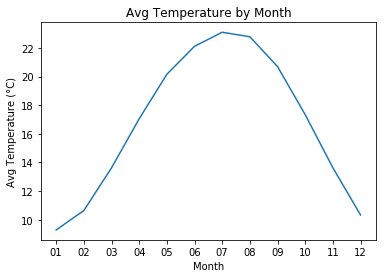

In [26]:
plt.plot(groupby_month)
plt.xlabel('Month')
plt.ylabel('Avg Temperature (°C)')
plt.title('Avg Temperature by Month')
plt.show()

#### What are the months of the year that has the highest temperature?
    * It is clear from the previous figure that the beginning of May to the end of September is the highest temperature period during all months of the year 

### U.S. City Demographic Data

In [27]:
percent_missing = demo_df.isnull().sum() * 100 / len(demo_df)
missing_value_df = pd.DataFrame({'column_name': demo_df.columns,
                                 'percent_missing': percent_missing})
missing_value_df 

,column_name,percent_missing
City,City,0.000000
State,State,0.000000
Median Age,Median Age,0.000000
Male Population,Male Population,0.103770
Female Population,Female Population,0.103770
Total Population,Total Population,0.000000
Number of Veterans,Number of Veterans,0.449671
Foreign-born,Foreign-born,0.449671
Average Household Size,Average Household Size,0.553442
State Code,State Code,0.000000


In [28]:
num_rows_before = demo_df.shape[0]

In [29]:
demo_df.dropna( inplace=True)

In [30]:
# Drop duplicates 
demo_df = demo_df.drop_duplicates()

In [31]:
num_rows_after = demo_df.shape[0]
print("number of rows before cleaning process: ",num_rows_before)
print("number of rows after cleaning process: ",num_rows_after)

number of rows before cleaning process:  2891
number of rows after cleaning process:  2875


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model




In [32]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="Untitled Workspace.png", width=900, height=900)

#### The country dimension table: 
- consist of a combination of data from (World Temperature +  immigration datasets ). 
- By combining these two datasets, analysts can investigate the relationship between global temperatures and immigration patterns to the US.


#### Us demographics dimension table:
- consist of a combination of data from (demographics  +  immigration datasets ). 
- The purpose of creating the US demographics dimension table is to provide a more complete understanding of the relationship between demographics and immigration at the US state level by combining data from both the demographics and immigration datasets. The table serves as a bridge between the two datasets, enabling efficient querying and analysis of the data, and allowing analysts to make informed decisions based on correlations and patterns discovered through the combined data, We could ask questions such as do populous states attract more visitors every month? 


#### The immigration calendar dimension table:
- comes from the immigration datasets and links to the immigration via arrdate, arrival_year, arrival_month, arrival_day, arrival_week, and arrival_weekday.
- The goal of creating this table is to create a table that cares about dates and times, which enables us to ask many questions, such as what are the most months of the year in which migration takes place, and what are the most years in which migration took place during the past ten years? Thus, this will help us to improve the services we provide in the months that have a small number of immigration and to know the reasons for that so that we can attract many immigrants to us later.


#### The visa type dimension table:
- comes from the immigration datasets and links to the immigration via the visa_type_key.
- The goal of creating the visa type dimension table is to provide more detailed information about the types of visas that individuals use to enter the country, as captured in the immigration dataset. By linking to the immigration fact table via the visa_type_key, analysts can better understand patterns and trends in immigration, such as which types of visas are most commonly used for which purposes and by whom. This information can then be used to make informed decisions and policy recommendations related to immigration. The visa type dimension table serves as a reference table that allows for efficient querying and analysis of the immigration data related to visa types.


#### The immigration fact table 
- It is the fact table of the data model. 
- This table's data comes from the immigration data sets and contains keys that link to the dimension tables. 
- The goal of creating the immigration fact table is to centralize and organize data related to immigration from various datasets, allowing for efficient querying, analysis, and informed decision-making.

#### 3.2 Mapping Out Data Pipelines
The pipeline steps are as follows:

get the datasets and download it >>> create df for each month in immigration dataset >>> Create visa_type dimension table >>> Create calendar dimension table >>> load the cleaned temp_data >>> Create country dimension table >>> Create immigration fact table >>> Load demographics data >>> Clean demographics data >>> Create demographic dimension table



 







### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

## Configuration process with AWS 

In [ ]:
import os
import configparser

config = configparser.ConfigParser()
config.read('config.cfg')

os.environ['AWS_ACCESS_KEY_ID']=configs['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']

### 1. The immigration calendar dimension table

In [ ]:
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.functions import monotonically_increasing_id

def create_immigration_calendar_dimension(df, output_data):
    """
    Description:
        - The following function generates a calendar dimension for immigration events, based on their arrival date.

    parameters: 
        - df: a Spark DataFrame containing immigration events.
        - output_data: a file path to store the resulting dimension DataFrame.
    
    return: 
        - a Spark DataFrame representing the calendar dimension.
    """
    # Define a UDF to convert SAS arrival date to datetime object
    get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    
    # Create initial calendar df from arrival date column
    calendar_df = df.select(['arrdate']).withColumn("arrdate", get_datetime(df.arrdate)).distinct()
    
    # Add other calendar columns to the dataframe
    calendar_df = calendar_df.withColumn('arrival_day', dayofmonth('arrdate'))
    calendar_df = calendar_df.withColumn('arrival_week', weekofyear('arrdate'))
    calendar_df = calendar_df.withColumn('arrival_month', month('arrdate'))
    calendar_df = calendar_df.withColumn('arrival_year', year('arrdate'))
    calendar_df = calendar_df.withColumn('arrival_weekday', dayofweek('arrdate'))

    # Create an ID field in the calendar dataframe
    calendar_df = calendar_df.withColumn('id', monotonically_increasing_id())
    
    # Write the calendar dimension to a parquet file
    partition_columns = ['arrival_year', 'arrival_month', 'arrival_week']
    calendar_df.write.parquet(output_data + "immigration_calendar", partitionBy=partition_columns, mode="overwrite")
    
    # Return the calendar dataframe
    return calendar_df


In [ ]:
output_data = "tables/"

In [ ]:
calendar_df = create_immigration_calendar_dimension(new_imm_df, output_data)

### 2. The country dimension table

In [42]:
def aggregate_country_temperatures(temp_df):
    """
    Aggregates clean temperature data at country level.
    
    :param temp_df: spark dataframe of clean global temperatures data
    :return: spark dataframe consisting of countries average temperatures
    """
    agg_df = temp_df.select(['Country', 'AverageTemperature']).groupby('Country').avg()
    agg_df = agg_df.withColumnRenamed('avg(AverageTemperature)', 'average_temperature')
    return agg_df

In [45]:
def create_country_dimension(df, temp_df, output_data):
    """
    Creates a country dimension from the immigration and World temperatures data.
    
    :param df: spark dataframe of immigration events
    :param temp_df: spark dataframe of global land temperatures data
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing country dimension
    """
    # Get the aggregated temperature data
    agg_temp = aggregate_country_temperatures(temp_df).toPandas()
    
    # Load the i94res to country mapping data
    mapping_codes = pd.read_csv('i94res.csv') 
    
    # Define UDFs to get country name and average temperature
    @udf('string')
    def get_average_temperature(country_name):
        avg_temp = agg_temp[agg_temp['Country'] == country_name]['average_temperature']
        if not avg_temp.empty:
            return str(avg_temp.iloc[0])
        return None
    
    @udf()
    def get_country_name(country_code):
        name = mapping_codes[mapping_codes['code'] == country_code]['Name'].iloc[0]
        if name:
            return name.title()
        return None
        
    # Select and rename i94res column
    dim_df = df.select(['i94res']).distinct().withColumnRenamed('i94res', 'country_code')
    
    # Create country_name column
    dim_df = dim_df.withColumn('country_name', get_country_name(dim_df.country_code))
    
    # Create average_temperature column
    dim_df = dim_df.withColumn('average_temperature', get_average_temperature(dim_df.country_name))
    
    # Write the dimension to a parquet file
    dim_df.write.parquet(output_data + "country", mode="overwrite")
    
    return dim_df
country_dim = create_country_dimension(new_imm_df, temp_df, output_data)
country_dim.show(5) 

+------------+------------+-------------------+
|country_code|country_name|average_temperature|
+------------+------------+-------------------+
|       692.0|     Ecuador|      20.5391705374|
|       299.0|    Mongolia|     -3.36548531952|
|       576.0| El Salvador|      25.2628525509|
|       735.0|  Montenegro|      10.2210401137|
|       206.0|   Hong Kong|      21.4236961538|
+------------+------------+-------------------+
only showing top 5 rows


### 3. The demographics dimension table

In [41]:
def create_demographics_dimension_table(df, output_data):
    """Create a US demographics dimension table from the US cities demographics data.
    
    :param df: Spark dataframe of US demographics survey data.
    :param output_data: Path to write dimension dataframe to.
    :return: Spark dataframe representing demographics dimension.
    """
    dim_df = df.withColumnRenamed('Median Age','median_age') \
            .withColumnRenamed('Male Population', 'male_population') \
            .withColumnRenamed('Female Population', 'female_population') \
            .withColumnRenamed('Total Population', 'total_population') \
            .withColumnRenamed('Number of Veterans', 'number_of_veterans') \
            .withColumnRenamed('Foreign-born', 'foreign_born') \
            .withColumnRenamed('Average Household Size', 'average_household_size') \
            .withColumnRenamed('State Code', 'state_code')
    dim_df = dim_df.withColumn('id', monotonically_increasing_id())
    
    dim_df.write.parquet(output_data + "demographics", mode="overwrite")
    
    return dim_df

In [ ]:
demographics_dim_df = create_demographics_dimension_table(demo_df, output_data)
demographics_dim_df.limit(5).toPandas()

### 4. The visa type dimension table

In [ ]:
def create_visa_type_dimension_table(df, output_data):
    """This function creates a visa type dimension from the immigration data.

    :param df: spark dataframe of immigration events
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing visa type dimension
    """
    # create visatype df from visatype column
    visatype_df = df.select(['visatype']).distinct()

    # add an id column
    visatype_df = visatype_df.withColumn('visa_type_key', monotonically_increasing_id())

    # write dimension to parquet file
    visatype_df.write.mode("overwrite").parquet(output_data + "visatype")

    return visatype_df


def get_visa_type_dimension(output_data):
    """This function reads the visa type dimension from a parquet file.

    :param output_data: path to read dimension dataframe from
    :return: spark dataframe representing visa type dimension
    """
    return spark.read.parquet(output_data + "visatype")

In [44]:
visatype_df = create_visa_type_dimension_table(new_immigration_df, output_data)
visatype_df.show(n=5)

+--------+-------------+
|visatype|visa_type_key|
+--------+-------------+
|      F2| 103079215104|
|     GMB| 352187318272|
|      B2| 369367187456|
|      F1| 498216206336|
|     CPL| 601295421440|
+--------+-------------+
only showing top 5 rows


### 4. The immigration fact table

In [ ]:
def create_immigration_fact_table(df, visa_type_df, output_data):
    """
    This function creates an immigration fact table from the immigration events and visa types data.

    :param df: spark dataframe of immigration events
    :param visa_type_df: spark dataframe of visa types
    :param output_data: path to write fact dataframe to
    :return: spark dataframe representing immigration fact table
    """
    # select columns and rename to align with data model
    df = df.select(
        col('cicid').alias('record_id'),
        col('i94res').alias('country_residence_code'),
        col('i94addr').alias('state_code'),
        col('visatype').alias('visa_type')
    )
    
    # join with visa types data to get visa_type_key
    dim_df = visa_type_df.select('visa_type', 'visa_type_key')
    df = df.join(dim_df, on='visa_type')
    
    # convert arrival date to datetime
    get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    df = df.withColumn('arrdate', get_datetime(df.arrdate))
    
    # add id column
    df = df.withColumn('id', monotonically_increasing_id())
    
    # write fact table to parquet file
    df.write.parquet(output_data + 'immigration_fact', mode='overwrite')
    
    return df


In [ ]:
immigration_fact_df = create_immigration_fact_table(new_imm_df, output_data)

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
def quality_checks(df, table_name):
    """Count checks on fact and dimension table to ensure completeness of data.
    :param df: spark dataframe to check counts on
    :param table_name: corresponding name of table
    """
    total_count = df.count()

    if total_count == 0:
        print(f"Data quality check failed for {table_name} with zero records!")
    else:
        print(f"Data quality check passed for {table_name} with {total_count:,} records.")
    return 0

In [43]:
table_dfs = {
    'immigration_fact': immigration_fact_df,
    'visa_type_dim': visatype_df,
    'calendar_dim': calendar_df,
    'usa_demographics_dim': demographics_dim_df,
    'country_dim': country_dim_f
}
for table_name, table_df in table_dfs.items():
    # quality check for table
    quality_checks(table_df, table_name)


Data quality check passed for immigration_fact with 3,096,313 records.
Data quality check passed for visa_type_dim with 17 records.
Data quality check passed for calendar_dim with 30 records.
Data quality check passed for usa_demographics_dim with 2,875 records.
Data quality check passed for country_dim with 229 records.


#### 4.3 Data dictionary 

#### check DataDictionary file 



#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
    - AWS S3 for data storage
    - Pandas for sample data set exploratory data analysis
    - PySpark for large data set data processing to transform staging table to dimensional table
* Propose how often the data should be updated and why.
    - Tables created from immigration and temperature data set should be updated monthly since the raw data set is built up monthly.
    - Tables created from demography data set could be updated annually since demography data collection takes time and high frequent demography might take high cost but generate wrong conclusion.
    - All tables should be update in an append-only mode.
* Write a description of how you would approach the problem differently under the following scenarios:
    * The data was increased by 100x.
         - If the data was increased by 100x, no problem --> Spark can do it.
     
    * The data populates a dashboard that must be updated on a daily basis by 7am every day.
        - To update on a daily basis I would use Apache Airflow to create a schedule to update all the data,
    
    * The database needed to be accessed by 100+ people.
        - If the data needs to be accessed by 100+ people, we can use Hive, Spark sql template views, ...